In [1]:
import datetime
import glob
import json
import os
from collections import defaultdict
from pathlib import Path
import traceback
import time
import warnings
import copy
import pathlib

import awkward as ak
import dask
import dask_awkward as dak
import hist.dask
import coffea
import numpy as np
import uproot
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("ggplot")

from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
from coffea import dataset_tools

import urllib
import utils
import warnings

warnings.filterwarnings("ignore")

# import input_files.utils

from dask.distributed import LocalCluster, Client, progress, performance_report

# local: single thread, single worker
# cluster = LocalCluster(n_workers=1, processes=False, threads_per_worker=1)
# client = Client(cluster)

# for UChicago
# update this to point to your own client!
# client = Client("tls://localhost:8786")

# create a folder for output tracking of uproot.open setup
MEASUREMENT_PATH = pathlib.Path(datetime.datetime.now().strftime("measurements/%Y-%m-%d_%H-%M-%S"))
os.makedirs(MEASUREMENT_PATH)

print(f"awkward: {ak.__version__}")
print(f"dask-awkward: {dak.__version__}")
print(f"uproot: {uproot.__version__}")
print(f"hist: {hist.__version__}")
print(f"coffea: {coffea.__version__}")

/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


awkward: 2.6.3
dask-awkward: 2024.3.0
uproot: 5.3.2
hist: 2.7.2
coffea: 2024.4.0


In [2]:
mc_file = "https://cernbox.cern.ch/remote.php/dav/public-files/BPIO76iUaeYuhaF/DAOD_PHYSLITE.37233417._000052.pool.root.1"

# download for subsequent use
local_file_name = "ttbar.root"
if not os.path.exists(local_file_name):
    urllib.request.urlretrieve(mc_file, filename=local_file_name)

    
def filter_name(name):
    return name in [
        "AnalysisElectronsAuxDyn.pt",
        "AnalysisElectronsAuxDyn.eta",
        "AnalysisElectronsAuxDyn.phi",
        "AnalysisElectronsAuxDyn.m",
        
        "AnalysisMuonsAuxDyn.pt",
        "AnalysisMuonsAuxDyn.eta",
        "AnalysisMuonsAuxDyn.phi",
        "AnalysisMuonsAuxDyn.m",
        
        "AnalysisJetsAuxDyn.pt",
        "AnalysisJetsAuxDyn.eta",
        "AnalysisJetsAuxDyn.phi",
        "AnalysisJetsAuxDyn.m",
        
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb",
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc",
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu",
        
        "EventInfoAuxDyn.mcEventWeights"
    ]


events = NanoEventsFactory.from_root(
    {local_file_name: "CollectionTree"},
    schemaclass=PHYSLITESchema,
    delayed=True,
    uproot_options=dict(filter_name=filter_name),
).events()

In [3]:
def calculate_jets_btagDL1d(events):
    
    BTagging = events.BTagging_AntiKt4EMPFlow
    
    f_c = 0.018
    DDL1 = BTagging.DL1dv01_pb/(f_c*BTagging.DL1dv01_pc + (1-f_c)*BTagging.DL1dv01_pu)
    # DDL1 = dak.map_partitions(dask.array.log, DDL1)
    DDL1 = np.log(DDL1)

    return DDL1

In [4]:
jets = events.Jets

jets["btagDL1d"] = calculate_jets_btagDL1d(events)

# print(events.Jets.fields)
print(events.fields)

['Electrons', 'Jets', 'BTagging_AntiKt4EMPFlow', 'EventInfo', 'Muons']


In [5]:
def calculate_trijet_mass(events):
    # pT > 30 GeV for leptons, > 25 GeV for jets
    selected_electrons = events.Electrons[events.Electrons.pt > 30 & (np.abs(events.Electrons.eta) < 2.1)]
    selected_muons = events.Muons[events.Muons.pt > 30 & (np.abs(events.Muons.eta) < 2.1)]
    
    jets = events.Jets
    jets["btagDL1d"] = calculate_jets_btagDL1d(events)
    selected_jets = jets[events.Jets.pt > 25 & (np.abs(events.Jets.eta) < 2.4)] 
    
    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least two b-tagged jets ("tag" means score above threshold)
    B_TAG_THRESHOLD = 2.456
    event_filters = event_filters & (ak.sum(selected_jets.btagDL1d > B_TAG_THRESHOLD, axis=1) >= 2)
    
    # apply filters
    selected_jets = selected_jets[event_filters]
    
    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system

    trijet["max_btag"] = np.maximum(trijet.j1.btagDL1d, np.maximum(trijet.j2.btagDL1d, trijet.j3.btagDL1d))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
    
    # trijet = trijet[ak.count(trijet.p4.pt, axis=1) > 0] # remove empty arrays. The empty arrays may occur due to the b tag selection
    
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    
    
    return ak.flatten(trijet_mass)

In [6]:
reconstructed_top_mass = calculate_trijet_mass(events)


hist_reco_mtop = hist.dask.Hist.new.Reg(16, 0, 375000, label="$m_{bjj}$").Double().fill(reconstructed_top_mass)

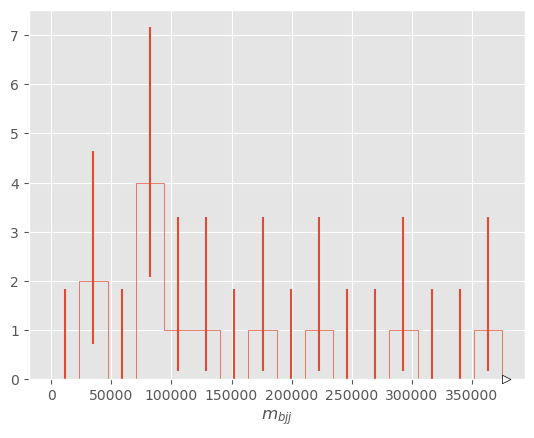

In [7]:
# perform computation and visualize
artists = hist_reco_mtop.compute().plot()

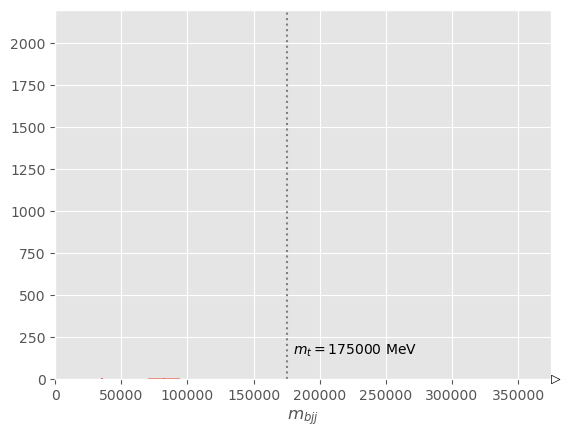

In [8]:
# and annotate the visualization
fig_dir = Path.cwd() / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

ax = artists[0].stairs.axes
fig = ax.get_figure()
ax.vlines(175000, 0, 2200, colors=["grey"], linestyle="dotted") 
ax.text(180000, 150, "$m_{t} = 175000$ MeV")
ax.set_xlim([0, 375000])
ax.set_ylim([0, 2200])

fig.savefig(fig_dir / "trijet_mass.png", dpi=300)
fig

## Now do the same with dataset tools

In [9]:
# for UChicago
# update this to point to your own client!
client = Client("tls://localhost:8786")

In [30]:
filenames_singletop_schan_lept_top = [
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621215._000011.pool.root.1"    
]

filenames_singletop_schan_lept_antitop = [
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621217._000012.pool.root.1"
]

filenames_tchan_BW50_lept_top = [
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000012.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000013.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000014.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000015.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000016.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000017.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000018.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000019.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000020.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000021.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000022.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621204._000023.pool.root.1"
]

filenames_tchan_BW50_lept_antitop = [
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000012.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000013.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000014.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000015.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000016.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000017.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000018.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000019.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000020.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621209._000021.pool.root.1"
]

filenames_tW_dyn_DR_incl_antitop = [
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000014.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000015.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000016.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000017.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000018.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000020.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000021.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000022.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000023.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000024.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000025.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000026.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000027.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000028.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000029.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000030.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000031.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000032.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000033.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000034.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000035.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202859._000036.pool.root.1"
]


filenames_tW_dyn_DR_incl_top = [
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000087.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000088.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000090.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000092.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000093.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000098.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000099.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000101.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000102.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000103.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000104.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000106.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000107.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000108.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000109.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000110.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000111.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000113.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000114.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000115.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000116.pool.root.1",
    "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38202865._000122.pool.root.1"
]

filenames_ttbar_hdamp258p75_nonallhad = [
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000012.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000013.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000014.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000015.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000017.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000018.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000019.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000021.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000023.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000024.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000025.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000026.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000028.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000031.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000033.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000034.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000035.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000036.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000037.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000106.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000132.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000152.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000153.pool.root.1",
    
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000155.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000163.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000164.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000201.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000212.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000230.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000244.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000427.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000520.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000595.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000626.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000643.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000665.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000669.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000671.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000674.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000675.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000012.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000013.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000014.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000015.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000016.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000017.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000018.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000019.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000020.pool.root.1",
    
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000021.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000022.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000023.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000024.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000026.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000027.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000028.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000029.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000030.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000031.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000032.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000033.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000034.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000035.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000109.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000110.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000111.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000112.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000113.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000115.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000117.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000118.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000119.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000121.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000122.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000124.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000126.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000128.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000129.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000130.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000132.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000133.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000159.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000160.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000163.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000164.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000165.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000167.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000168.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000169.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000171.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000172.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000174.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000175.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000176.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000178.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000179.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000180.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000181.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000182.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000183.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000223.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000224.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000225.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000227.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000228.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000229.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000230.pool.root.1",
    
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000231.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000232.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000233.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000234.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000236.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000237.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000239.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000240.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000242.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000243.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000244.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000245.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000247.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000248.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000250.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000251.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000252.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000253.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000255.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000256.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000257.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000258.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000260.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000262.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000263.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000264.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000265.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000266.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000267.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000268.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000269.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000270.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000271.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000272.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000273.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000274.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000275.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000276.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000277.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000278.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000279.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000281.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000282.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000283.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000285.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000287.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000288.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000290.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000291.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000292.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000293.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000294.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000295.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000346.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000347.pool.root.1",
    # "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000348.pool.root.1",
    
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000349.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000350.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000351.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000353.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000354.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000355.pool.root.1",
    
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000356.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000357.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000358.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000359.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000361.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000364.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000365.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000367.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000368.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000369.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000370.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000371.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000372.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000374.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000375.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000376.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000377.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000417.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000432.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000466.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620646._000488.pool.root.1"
]





fileset = {
            "singletop_schan_lept_top"  : 
                        {
                        'files': {name:'CollectionTree' for name in filenames_singletop_schan_lept_top},
                        'metadata': {"cross-section": 2.027, "filter-efficiency": 1.0, "k-factor": 1.017, "sum-of-weights":365019.0806794167, "process-label":"singletop_schan_lept"},
                        },
            "singletop_schan_lept_antitop":
                        {
                        'files': {name:'CollectionTree' for name in filenames_singletop_schan_lept_antitop},
                        'metadata': {"cross-section": 1.2674, "filter-efficiency": 1.0, "k-factor": 1.0167, "sum-of-weights":152312.88860154152, "process-label":"singletop_schan_lept"},
                        },
            "tchan_BW50_lept_top":
                        {
                        'files': {name:'CollectionTree' for name in filenames_tchan_BW50_lept_top},
                        'metadata': {"cross-section": 36.996, "filter-efficiency": 1.0, "k-factor": 1.1935, "sum-of-weights":124412662.10998064, "process-label":"tchan_BW50_lept"},
                        },
            "tchan_BW50_lept_antitop":
                        {
                        'files': {name:'CollectionTree' for name in filenames_tchan_BW50_lept_antitop},
                        'metadata': {"cross-section": 22.173, "filter-efficiency": 1.0, "k-factor": 1.1849, "sum-of-weights":44399910.88976225, "process-label":"tchan_BW50_lept"},
                        },
            "tW_dyn_DR_incl_antitop":
                        {
                        'files': {name:'CollectionTree' for name in filenames_tW_dyn_DR_incl_antitop},
                        'metadata': {"cross-section": 35.972, "filter-efficiency": 1.0, "k-factor": 1.0, "sum-of-weights":96216887.40345384, "process-label":"tW_dyn_DR_incl"},
                        },
            "tW_dyn_DR_incl_top":
                        {
                        'files': {name:'CollectionTree' for name in filenames_tW_dyn_DR_incl_top},
                        'metadata': {"cross-section": 36.003, "filter-efficiency": 1.0, "k-factor": 1.0, "sum-of-weights":95054189.43354416, "process-label":"tW_dyn_DR_incl"},
                        },
            "ttbar_hdamp258p75_nonallhad":
                        {
                        'files': {name:'CollectionTree' for name in filenames_ttbar_hdamp258p75_nonallhad},
                        'metadata': {"cross-section": 729.77, "filter-efficiency": 0.5437965, "k-factor": 1.139756362, "sum-of-weights": 24014984445.81677, "process-label":"ttbar_hdamp258p75_nonallhad"},
                        }
          }
        

samples, _ = dataset_tools.preprocess(fileset)


# workaround for https://github.com/CoffeaTeam/coffea/issues/1050 (metadata gets dropped, already fixed) 
for k, v in samples.items():
    v["metadata"] = fileset[k]["metadata"]

# Describe the b tagging value in detail here, i. e where it comes from

In [31]:
def create_histogram(events):
    
    
    # pT > 30 GeV for leptons, > 25 GeV for jets
    selected_electrons = events.Electrons[events.Electrons.pt > 30 & (np.abs(events.Electrons.eta) < 2.1)]
    selected_muons = events.Muons[events.Muons.pt > 30 & (np.abs(events.Muons.eta) < 2.1)]
    
    jets = events.Jets
    jets["btagDL1d"] = calculate_jets_btagDL1d(events)
    selected_jets = jets[events.Jets.pt > 25 & (np.abs(events.Jets.eta) < 2.4)] 

    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least two b-tagged jets ("tag" means score above threshold)
    B_TAG_THRESHOLD = 2.456
    event_filters = event_filters & (ak.sum(selected_jets.btagDL1d > B_TAG_THRESHOLD, axis=1) >= 2)   
    
    # apply filters
    selected_jets = selected_jets[event_filters]
    
    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system 
    
    
    trijet["max_btag"] = np.maximum(trijet.j1.btagDL1d, np.maximum(trijet.j2.btagDL1d, trijet.j3.btagDL1d))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
    
    # trijet = trijet[ak.count(trijet.p4.pt, axis=1) > 0] # remove empty arrays. The empty arrays may occur due to the b tag selection
    
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    
    reconstructed_top_mass = ak.flatten(trijet_mass)
    
    
    luminosity = 36100
    cross_section = events.metadata["cross-section"]
    filter_efficiency = events.metadata["filter-efficiency"]
    k_factor = events.metadata["k-factor"]
    sum_of_weights = events.metadata["sum-of-weights"]
    process_label = events.metadata["process-label"]
    
    mc_weight = events.EventInfo.mcEventWeights[:, 0][event_filters]
    
    lumi_weight = luminosity * cross_section * k_factor * filter_efficiency / sum_of_weights
        
    
    # hist_reco_mtop = hist.dask.Hist.new.Reg(16, 0, 375000, label="$m_{bjj}$").Weight().fill(reconstructed_top_mass, weight=lumi_weight*mc_weight)
        
    
    hist_reco_mtop = (
        hist.dask.Hist.new.Reg(25, 50, 550, name="m_reco_top", label=r"$m_{bjj}$ [GeV]")
        .StrCat([], name="process", label="Process", growth=True)
        .Weight()
    )
    hist_reco_mtop.fill(reconstructed_top_mass/1000, weight=lumi_weight*mc_weight, process=process_label)
    
    return {"hist_mtop": hist_reco_mtop}
    

In [32]:
tasks = dataset_tools.apply_to_fileset(create_histogram, 
                                       samples, 
                                       schemaclass=PHYSLITESchema,
                                       uproot_options=dict(filter_name=filter_name)
                                      )

In [33]:
%%time

# execute
(out, ) = dask.compute(tasks)

CPU times: user 842 ms, sys: 18.1 ms, total: 860 ms
Wall time: 4min 57s


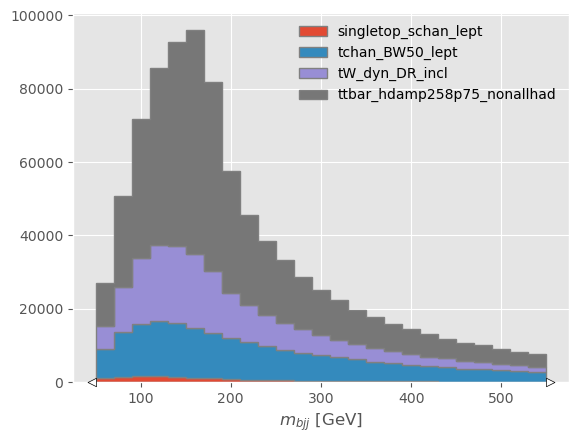

In [34]:
full_histogram_hist_mtop = sum([v["hist_mtop"] for v in out.values()])

artists = full_histogram_hist_mtop.stack("process").plot(
    stack=True, histtype="fill", linewidth=1,edgecolor="grey"
)

ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)